### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from random import shuffle
import time
from sklearn.metrics import roc_auc_score
import math
%matplotlib inline

### Load Data

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print('Training set shape :: {}, {}'.format(X_train.shape, y_train.shape))
print('Validation set shape :: {}, {}'.format(X_val.shape, y_val.shape))
print('Test set shape :: {}, {}'.format(X_test.shape, y_test.shape))

C:\Users\shekaul\AppData\Local\Continuum\anaconda3\envs\coursera\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Training set shape :: (50000, 28, 28), (50000,)
Validation set shape :: (10000, 28, 28), (10000,)
Test set shape :: (10000, 28, 28), (10000,)


### Define constants and hyperparameters

In [3]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_CLASSES = 10
PIXELS = 28 * 28
HIDDEN_UNITS1 = 250
HIDDEN_UNITS2 = 150
PRINT_STEP = 100

### Define graph

In [5]:
print(tf.__version__)

1.2.1


In [7]:
g = tf.Graph()

with g.as_default():
    X_placeholder = tf.placeholder(name = 'X', dtype = tf.float64, shape = (None, PIXELS))
    y_placeholder = tf.placeholder(name = 'y', dtype = tf.int64, shape = (None))
    
    with tf.variable_scope('hidden1', reuse = None):
        weights = tf.get_variable(name = 'weights', shape = [PIXELS, HIDDEN_UNITS1], dtype = tf.float64, 
                                  initializer = tf.contrib.layers.variance_scaling_initializer())
        biases = tf.get_variable(name='biases', shape = [HIDDEN_UNITS1], dtype = tf.float64,
                                  initializer = tf.zeros_initializer())
        hidden1 = tf.nn.relu(tf.matmul(X_placeholder, weights) + biases)
  
    with tf.variable_scope('hidden2', reuse = None):
        weights = tf.get_variable(name = 'weights', shape = [HIDDEN_UNITS1, HIDDEN_UNITS2], dtype = tf.float64, 
                                  initializer = tf.contrib.layers.variance_scaling_initializer())    
        biases = tf.get_variable(name='biases', shape = [HIDDEN_UNITS2], dtype = tf.float64,
                                  initializer = tf.zeros_initializer())                         
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)

    with tf.variable_scope('softmax_linear', reuse = None):
        weights = tf.get_variable(name = 'weights', shape = [HIDDEN_UNITS2, NUM_CLASSES], dtype = tf.float64,
                                  initializer = tf.contrib.layers.xavier_initializer())        
        biases = tf.get_variable(name='biases', shape = [NUM_CLASSES], dtype = tf.float64,
                                  initializer = tf.zeros_initializer())
        logits = tf.matmul(hidden2, weights) + biases
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = y_placeholder, logits = logits)
    
    optimizer = tf.train.AdamOptimizer()   
    
    train_op = optimizer.minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(logits,1), y_placeholder)
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    init = tf.global_variables_initializer()

### Defin helper Functions

In [8]:
# Function to reshape the input into suitable shape
def flatten_matrix(X):
    return X.reshape((X.shape[0], -1))

# Function to create mini batches
def create_batches(X, Y, batch_size):
    m =  X.shape[0]
    batches = []    
    permutations = np.random.permutation(m)    
    Shuffled_X = X[permutations, :]
    Shuffled_Y = Y[permutations]
    n = math.floor(m/batch_size)    
    for i in range(n):
        x = Shuffled_X[i * batch_size: (i + 1) * batch_size, :]
        y = Shuffled_Y[i * batch_size: (i + 1) * batch_size]        
        batch = (x, y)        
        batches.append(batch)  
    if m % batch_size != 0:
        index = (batch_size * n)
        x = X[index :, :]
        y = Y[index :]
        batch =(x, y)        
        batches.append(batch)
    return batches

# Function to encode labels to one hot encoding
def one_hot_encoding(y, num_classes):
    result = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        result[i, y[i]] = 1
    return result

### Train the Model

In [9]:
X_train = flatten_matrix(X_train)
X_test = flatten_matrix(X_test)
X_val = flatten_matrix(X_val)
sess = tf.Session(graph = g)
sess.run(init)
train_losses = []
test_losses = []
start_time = time.time()
for i in range(NUM_EPOCHS):
    batch = 0    
    for X_tr, y_tr in create_batches(X_train, y_train, BATCH_SIZE):
        batch = batch + 1
        feed_dict = {'X:0' : X_tr, 'y:0' : y_tr}
        _, train_loss = sess.run([train_op, loss], feed_dict = feed_dict)
        duration = time.time() - start_time
        if batch % PRINT_STEP == 0:
            #train_losses.append(train_loss)
            print("Epoch :: {}, Batch :: {}, Loss :: {:.3f} ({:.2f} seconds)".format(i + 1, batch, train_loss, 
                                                                                             duration))
    test_losses.append(sess.run(loss, feed_dict = {'X:0' : X_test, 'y:0' : y_test}))
    train_losses.append(sess.run(loss, feed_dict = {'X:0' : X_train, 'y:0' : y_train}))       

Epoch :: 1, Batch :: 100, Loss :: 0.428 (0.92 seconds)
Epoch :: 1, Batch :: 200, Loss :: 0.217 (1.68 seconds)
Epoch :: 1, Batch :: 300, Loss :: 0.160 (2.38 seconds)
Epoch :: 2, Batch :: 100, Loss :: 0.131 (4.74 seconds)
Epoch :: 2, Batch :: 200, Loss :: 0.110 (5.55 seconds)
Epoch :: 2, Batch :: 300, Loss :: 0.059 (6.23 seconds)
Epoch :: 3, Batch :: 100, Loss :: 0.045 (8.62 seconds)
Epoch :: 3, Batch :: 200, Loss :: 0.036 (9.33 seconds)
Epoch :: 3, Batch :: 300, Loss :: 0.071 (10.06 seconds)
Epoch :: 4, Batch :: 100, Loss :: 0.025 (12.48 seconds)
Epoch :: 4, Batch :: 200, Loss :: 0.051 (13.18 seconds)
Epoch :: 4, Batch :: 300, Loss :: 0.112 (13.92 seconds)
Epoch :: 5, Batch :: 100, Loss :: 0.029 (16.18 seconds)
Epoch :: 5, Batch :: 200, Loss :: 0.071 (16.88 seconds)
Epoch :: 5, Batch :: 300, Loss :: 0.114 (17.57 seconds)
Epoch :: 6, Batch :: 100, Loss :: 0.028 (19.88 seconds)
Epoch :: 6, Batch :: 200, Loss :: 0.013 (20.63 seconds)
Epoch :: 6, Batch :: 300, Loss :: 0.033 (21.31 seconds)


### Print accuracy of Model

In [10]:
feed_dict = {'X:0' : X_train,
            'y:0' : y_train}
acc = sess.run(accuracy, feed_dict = feed_dict)
print('Training Accuracy ::{}'.format(acc))

Training Accuracy ::0.9985600113868713


In [11]:
feed_dict = {'X:0' : X_val,
            'y:0' : y_val}
acc = sess.run(accuracy, feed_dict = feed_dict)
print('Validation Accuracy ::{}'.format(acc))

Validation Accuracy ::0.9789000153541565


In [12]:
feed_dict = {'X:0' : X_test,
            'y:0' : y_test}
acc = sess.run(accuracy, feed_dict = feed_dict)
print('Test Accuracy ::{}'.format(acc))

Test Accuracy ::0.9805999994277954


### Plot loss during training
Loss is noisy cause we are using minibatches. For smoothly decreasing loss change batch size to sample size

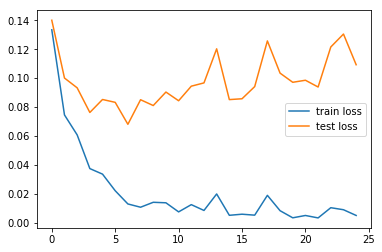

In [13]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])

### Print ROC AUC Score

In [14]:
predictions = sess.run(logits, feed_dict = {'X:0' : X_train})
predictions = one_hot_encoding(np.argmax(predictions, axis = 1), NUM_CLASSES)
training_score = roc_auc_score(one_hot_encoding(y_train, NUM_CLASSES), predictions)
print('Training AUC ROC Score :: {:.2f}'.format(training_score))

Training AUC ROC Score :: 1.00


In [15]:
predictions = sess.run(logits, feed_dict = {'X:0' : X_val})
predictions = one_hot_encoding(np.argmax(predictions, axis = 1), NUM_CLASSES)
training_score = roc_auc_score(one_hot_encoding(y_val, NUM_CLASSES), predictions)
print('Validation AUC ROC Score :: {:.2f}'.format(training_score))


Validation AUC ROC Score :: 0.99


In [16]:
predictions = sess.run(logits, feed_dict = {'X:0' : X_test})
predictions = one_hot_encoding(np.argmax(predictions, axis = 1), NUM_CLASSES)
training_score = roc_auc_score(one_hot_encoding(y_test, NUM_CLASSES), predictions)
print('Test AUC ROC Score :: {:.2f}'.format(training_score))

Test AUC ROC Score :: 0.99
